# Micrograd
Building neural networks from scratch. 

## The Neural Network Data Structure

In [1]:
# imports
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
class Value:

    def __init__(self, data: float) -> None:
        self.data = data

    # if we are printing an object of Value class, it will automatically call this function
    def __repr__(self) -> str:
        return f"Value(data={self.data})"

In [3]:
class Value:

    def __init__(self, data: float, _children=(), _operator='', label='') -> None:
        self.data = data
        self.gradient = 0.0 # initially this has no effect on the output, so 0
        self._prev = set(_children)
        self._operator = _operator
        self.label = label

    # if we are printing an object of Value class, 
    # it will automatically call this function
    # similar to toString method in Java
    def __repr__(self) -> str:
        return f"Value(data={self.data})"
    
    def __add__(self, other: Value) -> Value:
        out = Value(data=(self.data + other.data), _children=(self, other), _operator='+')
        return out
    
    def __mul__(self, other: Value) -> Value:
        out = Value(data=self.data * other.data, _children=(self, other), _operator='*')
        return out

    # probably not required but added it anyway
    def __sub__(self, other: Value) -> Value:
        out = Value(data=self.data - other.data, _children=(self, other), _operator='-')
        return out
    
    # probably not required but added it anyway
    # truediv is called when we perform a/b
    def __truediv__(self, other: Value) -> Value:
        out = Value(data=self.data / other.data, _children=(self, other), _operator='/')
        return out

    def tanh(self) -> Value:
        x = self.data
        t = (math.exp(2*x) - 1) / (math.exp(2*x) + 1)
        out = Value(data=t, _children=(self,), _operator='tanh')
        return out

In [4]:
a = Value(3.0, label='a')
print(a)

Value(data=3.0)


In [5]:
b = Value(-1.0, label='b')
b

Value(data=-1.0)

In [6]:
a+b

Value(data=2.0)

Internally it performs 
```python
    a.__add__(b)
```

In [7]:
a*b

Value(data=-3.0)

Internally it performs 
```python
    a.__mul__(b)
```

In [8]:
c = Value(20, label='c')

In [9]:
a+b*c

Value(data=-17.0)

**a + b * c** follows BODMAS rule i.e.
- completes b*c first
- adds a to the above result

## After Adding Children & Operator

In [10]:
d = a+b
d.label = 'd'

In [11]:
print("d = ", d)
print("d prev = ", d._prev)
print("d operator = ", d._operator)
print("d label = ", d.label)

d =  Value(data=2.0)
d prev =  {Value(data=3.0), Value(data=-1.0)}
d operator =  +
d label =  d


## Graphing the Neurons

In [12]:
from graphviz import Digraph

# build set of nodes and edges in the graph
def trace(root: Value):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_network(root: Value) -> Digraph:
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # rank direction LR -> left to right

    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        dot.node(name=uid, label="{ %s | data %.4f | gradient %.4f }" % (n.label, n.data, n.gradient), shape='record')
        # if the resulting node is result of a mathematical operation:
        if(n._operator):
            # creating an operation node
            dot.node(name=uid+n._operator, label=n._operator)
            # connecting it with the node
            dot.edge(uid + n._operator, uid)
    
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._operator)
    
    return dot

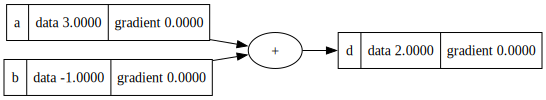

In [13]:
draw_network(d)

In [14]:
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a*b; e.label = 'e'
d = e + c; d.label = 'd'
f = Value(-2.0, label='f')
L = d * f; L.label = 'L'
L

Value(data=-8.0)

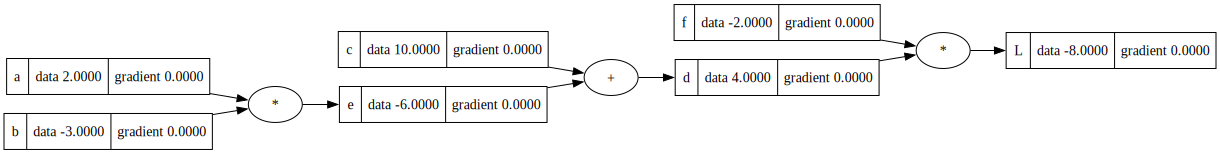

In [15]:
draw_network(L)

## Manual Back-Propagation

### Calculus: Definition of a Derivative as a Limit

```math
\frac{d}{dx} f(x) = \lim_{h \to 0} \frac{f(x + h) - f(x)}{h}
```

Starting from the last value node - L. 

The gradient of L with respect to itself is 1.

In [16]:
L.gradient = 1

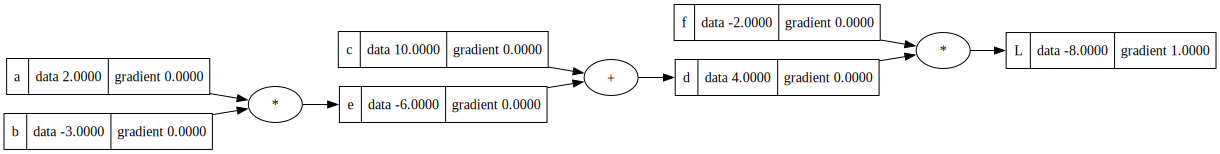

In [17]:
draw_network(L)

Back-propagation is the process of finding out how a previous value affects the final value 'L'.

When we back-propagate, we find out what is the effect any of the previous nodes on L:
- effect of changing a 
- effect of changing b
- effect of changing e 
- effect of changing c 
- effect of changing d 
- effect of changing f

In [18]:
def effect_of_a_on_L():
    # small step size 'h'
    h = 0.001

    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a*b; e.label = 'e'
    d = e + c; d.label = 'd'
    f = Value(-2.0, label='f')
    L = d * f; L.label = 'L'
    L1 = L.data

    a = Value(2.0+h, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a*b; e.label = 'e'
    d = e + c; d.label = 'd'
    f = Value(-2.0, label='f')
    L = d * f; L.label = 'L'
    L2 = L.data

    print((L2-L1)/h)
effect_of_a_on_L()

6.000000000000227


### How Do 'd' & 'f' Affect 'L

In [19]:
# gradient of d with respect to L
# L = d * f  or f(d) = d * f
# From calculus, we know that:
    #  dL/dd = f
    # Proof:
        # dL/dd = lim h --> 0 ( (f(d+h) - f(d))/h )
            #   = lim h --> 0 ( ( (d+h)*f - d*f )/h )
            #   = lim h --> 0 ( ( df + hf - df )/h )
            #   = lim h --> 0 ( hf / h)
            #   =  f
d.gradient = f.data

# similarly dL/df = d
f.gradient = d.data

In [20]:
# Confirming the above statement is correct:

def effect_of_f_on_L():
    # small step size 'h'
    h = 0.001

    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a*b; e.label = 'e'
    d = e + c; d.label = 'd'
    f = Value(-2.0, label='f')
    L = d * f; L.label = 'L'
    L1 = L.data

    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a*b; e.label = 'e'
    d = e + c; d.label = 'd'
    f = Value(-2.0+h, label='f')
    L = d * f; L.label = 'L'
    L2 = L.data

    print((L2-L1)/h)
effect_of_f_on_L()

3.9999999999995595


Why don't we get 4 exactly? 

This is to do with how precise floating point values are stored and performing calculations on those. 
Interesting read: https://docs.python.org/3/tutorial/floatingpoint.html 

In [21]:
# Confirming the above statement is correct:

def effect_of_d_on_L():
    # small step size 'h'
    h = 0.001

    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a*b; e.label = 'e'
    d = e + c; d.label = 'd'
    f = Value(-2.0, label='f')
    L = d * f; L.label = 'L'
    L1 = L.data

    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a*b; e.label = 'e'
    d = e + c; d.label = 'd'
    d.data += h
    f = Value(-2.0, label='f')
    L = d * f; L.label = 'L'
    L2 = L.data

    print((L2-L1)/h)
effect_of_d_on_L()

-2.000000000000668


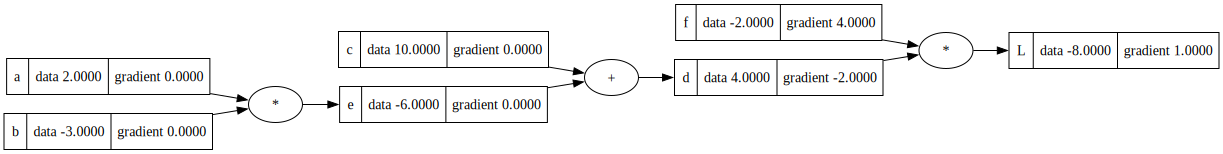

In [22]:
draw_network(L)

### How Do 'e' & 'c' Affect 'L'

We know that, 'c' affects 'd' (dd/dc) and 'd' affects 'L' (dL/dd)
what's dL/dc?

This can be done using the chain rule

### Calculus: Chain Rule

When z is a function of y, and y is a function of x:
```math
z = f(y)
```
```math
y = f(x)
```
Then the chain rule can be stated as:
```math
\frac{dz}{dx} = \frac{dz}{dy} \cdot \frac{dy}{dx}
```

Our network expressions are as follows:
```math
d = e + c
```
```math
L = d +f
```
Now using the chain rule, we can see the impact of 'c' on 'L' as:
```math
\frac{dL}{dc} = \frac{dL}{dd} \cdot \frac{dd}{dc}
```
Let's calculate the impact of 'c' on 'd' using the definition of a derivative:
```math
\frac{dd}{dc} = \lim_{h \to 0} \frac{f(c + h) - f(c)}{h}
```
```math
\frac{dd}{dc} = \lim_{h \to 0} \frac{(e+c+h) - (e+c))}{h}
```
```math
\frac{dd}{dc} = \lim_{h \to 0} \frac{e+c+h-e-c}{h}
```
```math
\frac{dd}{dc} = \lim_{h \to 0} \frac{h}{h}
```
```math
\frac{dd}{dc} = 1
```
Also, we already know that 
```math
\frac{dL}{dd} = -2
```
Now putting it all together in the chain rule:
```math
\therefore \frac{dL}{dc} = -2 \times 1 = -2
```

Similarly using the chain rule, we can see the impact of 'e' on 'L' as:
```math
\frac{dL}{de} = \frac{dL}{dd} \cdot \frac{dd}{de}
```
```math
\frac{dd}{de} = 1
```
```math
\therefore \frac{dL}{de} = 1 \times -2 = -2
```


Local derivatives of functions with a '+' operation, will always have derivate = 1. 

Andrej also explains how we can think of this as the gradient of the next node (d) being routed to the gradient of the child nodes (e and c). In this case the gradient of 'd' which is -2 is also the gradient of 'c' and 'e' (since d = e+c)

In [23]:
# for '+' operations: route the parent's gradient to children
e.gradient = d.gradient
c.gradient = d.gradient

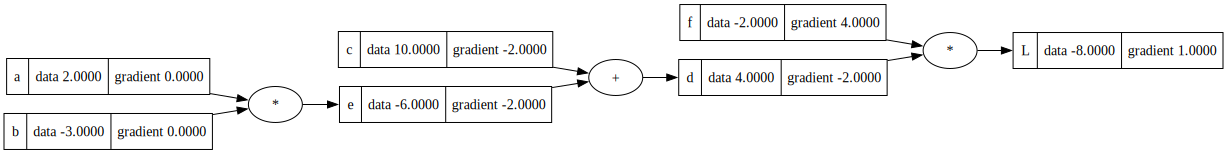

In [24]:
draw_network(L)

### How Do 'a' & 'b' Affect 'L'

Similarly, to find how a change in 'a' affects 'L':
```math
\frac{dL}{da} = \frac{dL}{de} \times \frac{de}{da}
```
```math
\because  \frac{de}{da} = b = -3
```
```math
\frac{dL}{da} = -2 \times -3 = 6
```

To find out how a change in 'b' affects 'L':
```math
\frac{dL}{db} = \frac{dL}{de} \times \frac{de}{db} = -2 \times 2 = -4
```

In [25]:
a.gradient = e.gradient * b.data
b.gradient = e.gradient * a.data

## Final Graph After 1 Round of Back Propagation

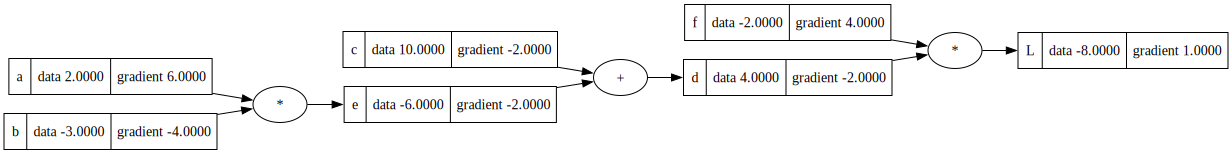

In [26]:
draw_network(L)

## How To Increase The Value of Output: 'L'

If we want 'L' to increase, we need to go in the direction of the gradient in all the leaf nodes  (that we usually have control over).

In [27]:
# taking a small step size in the direction of the gradient of the leaf nodes:

a.data += 0.01 * a.gradient
b.data += 0.01 * b.gradient
c.data += 0.01 * c.gradient
f.data += 0.01 * f.gradient

# now that we have updated the data, rewriting the forward pass
e = a * b; e.label = 'e'
d = e + c; d.label = 'd'
L = d * f; L.label = 'L'

print(L.data)

-7.286496


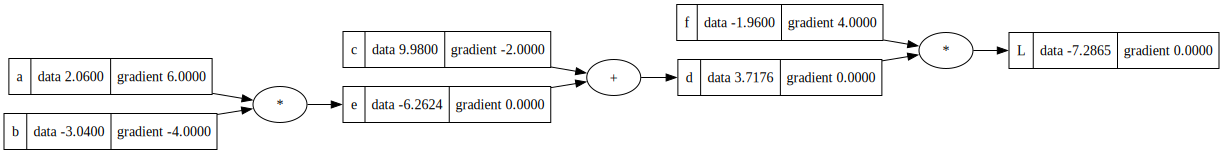

In [28]:
draw_network(L)

Previously the value of 'L' was -8. Now after taking a small step size of 0.01 in the direction of the gradient, we can see that 'L' has become more positive (-7.286).

# Basic Neural Network

In [29]:
# inputs as x1, x2

x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights as w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias of the neuron as b
b = Value(6.8813735870195432, label='b')

In [30]:
# computing x1*w1 + x2*w2 + b
x1w1 = x1 * w1; x1w1.label = 'x1*w1'
x2w2 = x2 * w2; x2w2.label = 'x2*w2'

x1wi_x2w2 = x1w1 + x2w2; x1wi_x2w2.label = 'x1w1 + x2w2'

n = x1wi_x2w2 + b; n.label = 'n'

o = n.tanh(); o.label = 'o'

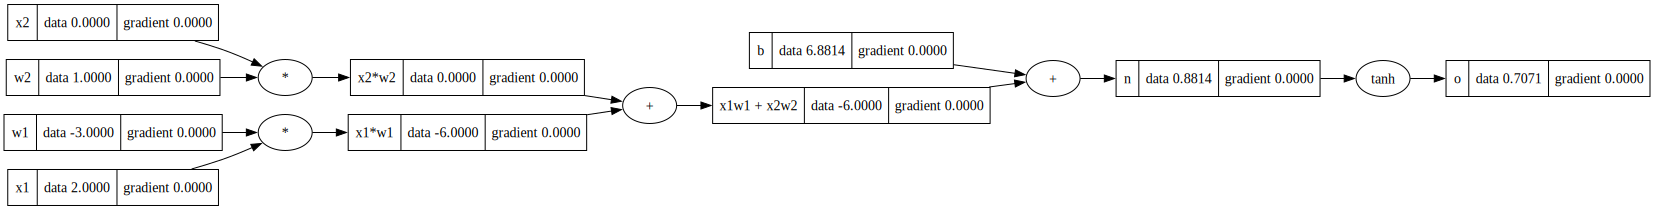

In [31]:
draw_network(o)

# Activation Functions
(A.k.a squashing functions)
## TanH
Hyperbolic Tangent that maps inputs to values in the range (-1, 1).

In [41]:
x = np.arange(-5,5,0.2)

Text(0, 0.5, 'Output')

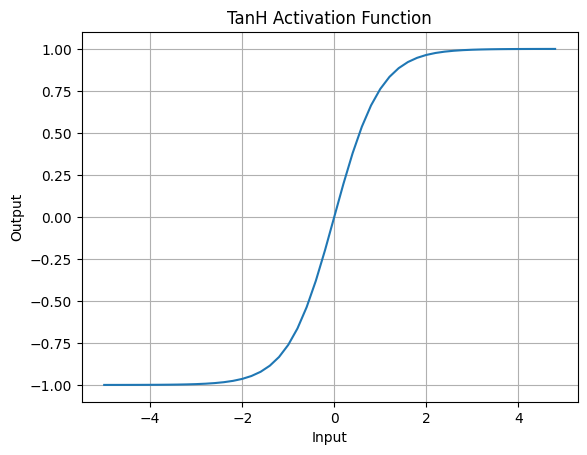

In [42]:
# tanh
plt.plot(x, np.tanh(x)); plt.grid()
plt.title('TanH Activation Function')
plt.xlabel('Input')
plt.ylabel('Output')

## Sigmoid
Maps all real numbers to values between 0 and 1.

In [43]:
def sigmoid(x: float) -> float:
    return 1/(1 + np.exp(-x))

Text(0, 0.5, 'Output')

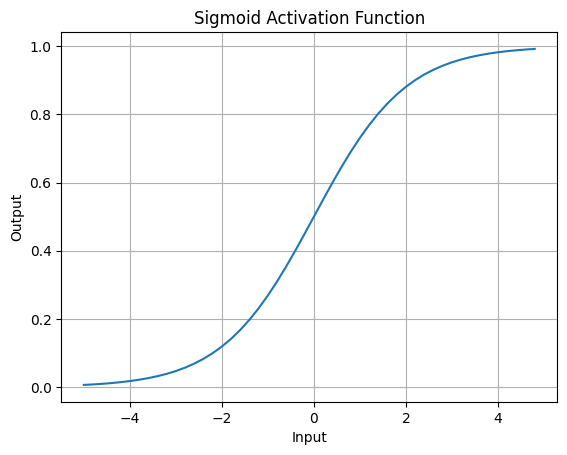

In [44]:
# sigmoid 
plt.plot(x, sigmoid(x)); plt.grid()
plt.title('Sigmoid Activation Function')
plt.xlabel('Input')
plt.ylabel('Output')

## ReLU: Rectified Linear Unit
Sets negative values to 0 and leaves positive values unchanged.

Text(0, 0.5, 'Output')

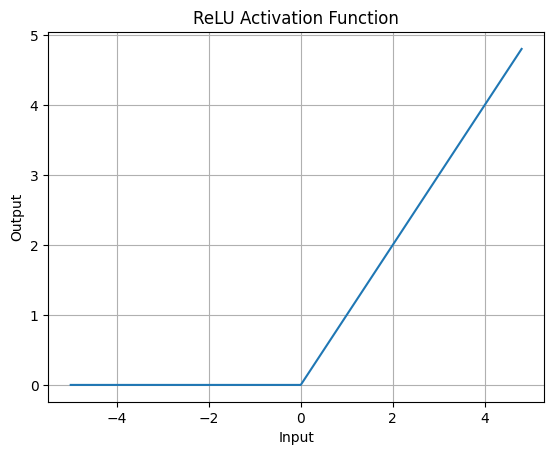

In [45]:
plt.plot(x, np.maximum(0, x)); plt.grid()
plt.title('ReLU Activation Function')
plt.xlabel('Input')
plt.ylabel('Output')

## Softmax
Maps all real numbers to a probability distribution over multiple classes.

In [46]:
def softmax(x: np.ndarray) -> np.ndarray:
    return np.exp(x) / np.sum(np.exp(x))

Text(0, 0.5, 'Output')

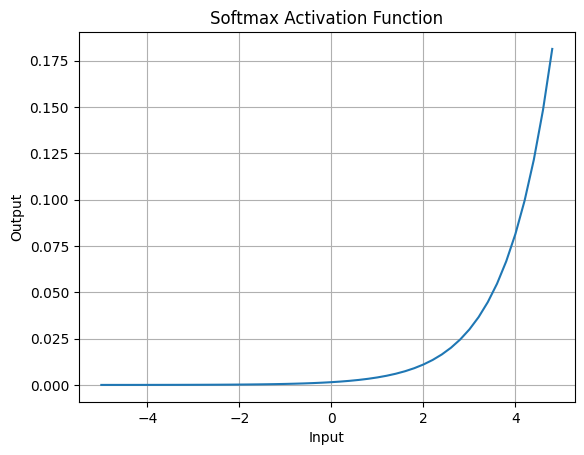

In [47]:
plt.plot(x, softmax(x)); plt.grid()
plt.title('Softmax Activation Function')
plt.xlabel('Input')
plt.ylabel('Output')